## Load data

In [44]:
#https://www.kaggle.com/code/mst8823/19th-place-best-single-model-resbilstm#BiLSTM-:-19th-Plath-Best-Single-Model-%5B-CV:0.1302-LB:0.1147-%5D

In [45]:
!pwd

/home/minkoo/serverity_prediction/notebook


In [46]:
import tensorflow as tf
import random 
import numpy as np
import pandas as pd
import sys
import os
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as ss
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [47]:
#Fixed Parameters
RANDOM = 0
MAX_LEN = 240
SLICE_SIZE = 6
GAP_TIME = 0
PREDICTION_WINDOW = 12
GRAY_AREA = 3

#data loading
COHORT = ["all","micu"]
IMPUTE = ["ref_val","icu_ave","bfill_6h_drop","dropref","bfill_6h","no_bfill"]
#impute with reference value
#impute with ICU average
#impute with bfill 6h and drop data with more than 5 empty columns  ==> then fill ref value
#impute with bfill 6h ==> then fill ref value
SAMPLING = ["worst","mean","first"]
mimic = os.path.join("../../Covid19-severity-prediction/data/mimic",COHORT[0],IMPUTE[0],SAMPLING[0])+".h5"
files = [ mimic,
          '../../Covid19-severity-prediction/data/ku-icu/dropref/ku_rICU_worst.h5' ,
          '../../Covid19-severity-prediction/data/ku-covid/dropref/ku_covid_worst.h5',
          '../data/raw_data/KUICU_3rd.h5']

mode = "test"
#mode = "train"

#data processing params
GRAY = False
LIMIT_TIMESTEP = False
USE_SCORES = False
PLOT_DIST = False
COMPUTE_LSTM_IMPORTANCE = False
NO_CBC = False

# model param
BATCH_SIZE = 128
EPOCHS = 20
KEEP_PROB = 0.8
REGULARIZATION = 0.01
LEARNING_RATE = 0.0003
# learning_rate = 0.0003
#learning_rate = 0.00001
#NUM_HIDDEN = [128, 128, 128]
#NUM_HIDDEN = [128, 64, 32]

In [48]:
vital = ['rr','hr','spo2','sbp','dbp','temp']
CBC = ['hct','hb','platelets','wbc','rbc','mch','mchc','mcv']
ABGA = ['ph','hco3', 'po2','pco2','sao2','fio2','pfratio']
COLS = vital+CBC+ABGA
ID_COLS= ['subject_id', 'hadm_id', 'icustay_id', 'hours_in']


D = []
for i, file in enumerate(files):
    print(file)
    temp = {}
    temp['X'] = pd.read_hdf(file,'vitals_labs').reset_index()
    temp['Y'] = pd.read_hdf(file,'interventions').reset_index()
    temp['info'] = pd.read_hdf(file,'patients').reset_index()
    D.append(temp)
    print(temp['X'].columns)
    print(temp['Y'].columns)
    print(len(temp['X'].columns))
D[0]['info'].rename(columns={"los_icu":"los"},inplace=True)
D[1]['info']['los'] = (D[1]['info']['los'] / np.timedelta64(1, 'h'))/ 24
D[2]['info']['los'] = (D[2]['info']['los'] / np.timedelta64(1, 'h'))/ 24
D[3]['info']['los'] = (D[3]['info']['los'] / np.timedelta64(1, 'h'))/ 24

../../Covid19-severity-prediction/data/mimic/all/ref_val/worst.h5


/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modif

Index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'absolute_time',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'vent'], dtype='object')
29
../../Covid19-severity-prediction/data/ku-icu/dropref/ku_rICU_worst.h5
Index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'absolute_time',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M'],
      dtype='object')
Index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'vent'], dtype='object')
29
../../Covid19-severity-prediction/data/ku-covid/dropref/ku_covid_worst.h5
Index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'abso

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tables/array.py:241: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modif

In [49]:
for i in range(len(files)):
    a= D[i]['info']['MV_ICU'].sum()
    b=len(D[i]['info']['MV_ICU'])
    print(a,b,a/b)

print(D[0]['Y']['vent'].sum())
print(len(D[0]['Y']))
print(D[0]['Y']['vent'].sum()/len(D[0]['Y']))

3628 25765 0.14081117795458956
190 1695 0.11209439528023599
34 107 0.3177570093457944
90 297 0.30303030303030304
479428
2250548
0.213027227146455


In [50]:
tab = []
for i in range(len(files)):
    a = D[i]['info'].iloc[: , 1:] 
    b = D[i]['X'].groupby(['subject_id','hadm_id','icustay_id']).mean().reset_index().drop(['age'],axis=1)
    tab.append(pd.merge(a, b, left_on=['subject_id','hadm_id','icustay_id'], right_on=['subject_id','hadm_id','icustay_id'], how='inner'))
tab[0]

,subject_id,hadm_id,icustay_id,gender,ethnicity,age,insurance,admittime,diagnosis_at_admission,dischtime,...,mcv,ph,hco3,po2,pco2,sao2,fio2,pfratio,gender_F,gender_M
0,4,185777,294638,F,WHITE,47.845,Private,2191-03-16 00:28:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-23 18:41:00,...,93.000,7.470,21.000,74.000,28.000,94.000,0.577,136.031,1.000,0.000
1,6,107064,228232,F,WHITE,65.942,Medicare,2175-05-30 07:15:00,CHRONIC RENAL FAILURE/SDA,2175-06-15 16:00:00,...,89.180,7.400,15.685,87.500,40.000,97.000,0.210,416.667,1.000,0.000
2,11,194540,229441,F,WHITE,50.148,Private,2178-04-16 06:18:00,BRAIN MASS,2178-05-11 19:00:00,...,85.026,7.400,25.487,87.500,40.000,97.000,0.210,416.667,1.000,0.000
3,13,143045,263738,F,WHITE,39.866,Medicaid,2167-01-08 18:43:00,CORONARY ARTERY DISEASE,2167-01-15 15:15:00,...,87.455,7.385,23.455,370.273,42.182,97.000,1.000,370.273,1.000,0.000
4,18,188822,298129,M,WHITE,50.842,Private,2167-10-02 11:18:00,HYPOGLYCEMIA;SEIZURES,2167-10-04 16:15:00,...,83.548,7.540,24.806,198.000,29.000,98.000,0.210,942.857,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25760,99982,151454,221194,M,WHITE,65.158,Medicare,2156-11-28 11:56:00,TVR,2156-12-08 13:45:00,...,98.375,7.512,30.000,164.125,39.292,80.000,1.000,164.125,0.000,1.000
25761,99983,117390,286606,M,UNKNOWN/NOT SPECIFIED,78.577,Medicare,2193-04-26 11:35:00,ST ELEVATION MYOCARDIAL INFARCTION;CORONARY AR...,2193-04-29 13:30:00,...,92.320,7.400,28.360,87.500,40.000,97.000,0.210,416.667,0.000,1.000
25762,99991,151118,226241,M,WHITE,47.729,Private,2184-12-24 08:30:00,DIVERTICULITIS/SDA,2185-01-05 12:15:00,...,85.289,7.350,26.197,189.000,35.000,97.000,0.400,472.500,0.000,1.000
25763,99992,197084,242052,F,WHITE,65.772,Medicare,2144-07-25 18:03:00,RETROPERITONEAL HEMORRHAGE,2144-07-28 17:56:00,...,88.438,7.400,23.250,87.500,40.000,97.000,0.210,416.667,1.000,0.000


In [51]:
for i in range(len(files)):
    a= tab[i]['MV_ICU'].sum()
    b=len(tab[i]['MV_ICU'])
    print(a,b,a/b)
    

3628 25765 0.14081117795458956
178 1683 0.10576351752822341
34 107 0.3177570093457944
90 297 0.30303030303030304


In [52]:
from tableone import TableOne
columns = ['age', 'los', 'gender', 'MV_ICU', 
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio']
categorical = ['gender']
groupby = 'MV_ICU'
nonnormal = ['age', 'los']
rename ={'los': 'Length of Stay', 'MV_ICU': 'In-hospital MV'}
table = []
for i in range(len(files)):
       table.append(TableOne(tab[i], columns, categorical, groupby, nonnormal, rename = rename, missing=False, pval=True,  smd=True,
                  htest_name=True))
table[0]

Grouped by In-hospital MV                                                                         
                                                   Overall                 0                 1 P-Value               Test SMD (0,1)
n                                                    25765             22137              3628                                     
age, median [Q1,Q3]                       65.7 [51.9,78.6]  65.6 [51.5,78.8]  66.3 [53.9,77.2]   0.483     Kruskal-Wallis     0.038
Length of Stay, median [Q1,Q3]               1.9 [1.1,3.6]     1.8 [1.1,2.9]    6.9 [3.8,13.3]  <0.001     Kruskal-Wallis     1.020
gender, n (%)                  F              11736 (45.6)      10213 (46.1)       1523 (42.0)  <0.001        Chi-squared     0.084
                               M              14029 (54.4)      11924 (53.9)       2105 (58.0)                                     
rr, mean (SD)                                   18.9 (4.6)        18.8 (3.9)        19.3 (7.4)  <0.001  Two Sample T-test     0.093
hr, mean (SD)                                  83.5 (15.5)       82.6 (14.9)       88.5 (18.1)  <0.001  Two Sample T-test     0.354
spo2, mean (SD)                                 96.5 (3.1)        96.5 (3.2)        96.4 (2.8)   0.100  Two Sample T-test    -0.028
sbp, mean (SD)                                121.9 (18.3)      121.9 (17.9)      122.2 (20.4)   0.342  Two Sample T-test     0.018
dbp, mean (SD)                                 61.4 (11.6)       61.5 (11.4)       60.6 (12.8)  <0.001  Two Sample T-test    -0.073
temp, mean (SD)                                 36.8 (0.5)        36.8 (0.5)        36.8 (0.7)   0.446  Two Sample T-test     0.015
hct, mean (SD)                                  32.7 (5.2)        32.8 (5.2)        32.4 (5.4)  <0.001  Two Sample T-test    -0.079
hb, mean (SD)                                   11.1 (1.9)        11.1 (1.9)        10.9 (1.9)  <0.001  Two Sample T-test    -0.099
platelets, mean (SD)                         224.8 (109.4)     226.0 (108.1)     217.4 (116.6)  <0.001  Two Sample T-test    -0.076
wbc, mean (SD)                                  11.4 (8.5)        11.2 (8.8)        12.3 (6.5)  <0.001  Two Sample T-test     0.141
rbc, mean (SD)                                   3.7 (0.6)         3.7 (0.6)         3.6 (0.7)  <0.001  Two Sample T-test    -0.102
mch, mean (SD)                                  30.3 (2.5)        30.3 (2.5)        30.4 (2.5)   0.003  Two Sample T-test     0.054
mchc, mean (SD)                                 33.9 (1.4)        33.9 (1.4)        33.9 (1.5)   0.324  Two Sample T-test    -0.018
mcv, mean (SD)                                  89.4 (6.5)        89.4 (6.5)        89.8 (6.6)  <0.001  Two Sample T-test     0.070
ph, mean (SD)                                    7.4 (0.1)         7.4 (0.1)         7.4 (0.1)  <0.001  Two Sample T-test    -0.132
hco3, mean (SD)                                 24.3 (4.0)        24.3 (3.9)        24.0 (4.6)  <0.001  Two Sample T-test    -0.072
po2, mean (SD)                                113.1 (68.3)      104.6 (53.0)     164.7 (113.4)  <0.001  Two Sample T-test     0.678
pco2, mean (SD)                                 40.5 (7.5)        40.4 (6.8)       41.4 (10.7)  <0.001  Two Sample T-test     0.110
sao2, mean (SD)                                 94.2 (8.3)        94.8 (7.5)       90.7 (11.6)  <0.001  Two Sample T-test    -0.424
fio2, mean (SD)                                  0.4 (0.2)         0.3 (0.2)         0.7 (0.3)  <0.001  Two Sample T-test     1.917
pfratio, mean (SD)                           384.4 (224.2)     406.6 (222.7)     248.7 (181.3)  <0.001  Two Sample T-test    -0.778

In [53]:
tab[0]['Cohort_Type'] = 'MIMIC-III'
tab[1]['Cohort_Type'] = 'KU-ICU'
tab[2]['Cohort_Type'] = 'KU-COVID-19'
tab[3]['Cohort_Type'] = 'KU-TEST'
columns = ['age', 'los', 'gender', 'MV_ICU', 'Cohort_Type',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio']
concat_tab = pd.concat([tab[0][columns], tab[1][columns],tab[2][columns],tab[3][columns]],axis=0).reset_index(drop=True)
concat_tab

,age,los,gender,MV_ICU,Cohort_Type,rr,hr,spo2,sbp,dbp,...,mch,mchc,mcv,ph,hco3,po2,pco2,sao2,fio2,pfratio
0,47.845,1.678,F,0,MIMIC-III,24.220,91.829,97.024,125.463,72.366,...,30.771,33.141,93.000,7.470,21.000,74.000,28.000,94.000,0.577,136.031
1,65.942,3.673,F,0,MIMIC-III,14.090,86.146,97.708,155.045,60.112,...,29.018,32.667,89.180,7.400,15.685,87.500,40.000,97.000,0.210,416.667
2,50.148,1.584,F,0,MIMIC-III,18.154,84.590,96.718,106.128,54.308,...,28.738,33.877,85.026,7.400,25.487,87.500,40.000,97.000,0.210,416.667
3,39.866,3.666,F,1,MIMIC-III,14.500,72.500,96.818,128.500,63.909,...,30.109,34.373,87.455,7.385,23.455,370.273,42.182,97.000,1.000,370.273
4,50.842,1.288,M,0,MIMIC-III,19.742,109.323,96.710,140.323,81.419,...,29.290,35.026,83.548,7.540,24.806,198.000,29.000,98.000,0.210,942.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27847,92.000,1.000,M,1,KU-TEST,33.000,132.000,97.000,89.000,33.000,...,30.300,33.643,90.129,7.302,18.171,80.700,35.300,94.686,0.210,336.100
27848,79.000,5.000,M,0,KU-TEST,22.605,74.700,96.721,114.901,73.695,...,32.455,34.173,94.878,7.398,25.700,133.400,41.200,99.000,0.210,638.300
27849,83.000,1.000,F,0,KU-TEST,21.569,90.980,97.471,117.275,66.765,...,31.367,33.667,93.237,7.407,20.176,95.700,31.724,97.310,0.286,334.114
27850,84.000,0.000,F,0,KU-TEST,17.375,101.375,99.292,112.167,67.875,...,34.913,36.429,95.892,7.508,19.575,100.400,24.417,98.258,0.258,386.312


In [54]:
from tableone import TableOne
columns = ['age', 'los', 'gender', 'MV_ICU', 
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio']
categorical = ['gender','MV_ICU']
groupby = 'Cohort_Type'
nonnormal = ['age', 'los']
rename ={'los': 'Length of Stay', 'MV_ICU': 'In-hospital MV'}
table = []
con_table = TableOne(concat_tab, columns, categorical, groupby, nonnormal, rename = rename, missing=False, pval=True, htest_name=True)
con_table.to_excel('tableone.xlsx')
con_table

Grouped by Cohort_Type                                                                                                
                                                Overall       KU-COVID-19            KU-ICU           KU-TEST         MIMIC-III P-Value            Test
n                                                 27852               107              1683               297             25765                        
age, median [Q1,Q3]                    65.8 [52.2,78.4]  65.0 [53.5,76.5]  66.0 [56.0,76.0]  73.0 [62.0,81.0]  65.7 [51.9,78.6]  <0.001  Kruskal-Wallis
Length of Stay, median [Q1,Q3]            2.0 [1.1,3.9]   15.4 [9.6,26.7]    5.6 [2.1,11.0]     3.0 [1.0,7.0]     1.9 [1.1,3.6]  <0.001  Kruskal-Wallis
gender, n (%)                  F           12510 (44.9)         36 (33.6)        638 (37.9)        100 (33.7)      11736 (45.6)  <0.001     Chi-squared
                               M           15342 (55.1)         71 (66.4)       1045 (62.1)        197 (66.3)      14029 (54.4)                        
In-hospital MV, n (%)          0           23922 (85.9)         73 (68.2)       1505 (89.4)        207 (69.7)      22137 (85.9)  <0.001     Chi-squared
                               1            3930 (14.1)         34 (31.8)        178 (10.6)         90 (30.3)       3628 (14.1)                        
rr, mean (SD)                                18.9 (4.5)        20.0 (3.1)        18.6 (2.7)        20.3 (4.7)        18.9 (4.6)  <0.001   One-way ANOVA
hr, mean (SD)                               83.3 (15.5)       76.2 (15.6)       79.7 (13.7)       88.6 (18.1)       83.5 (15.5)  <0.001   One-way ANOVA
spo2, mean (SD)                              96.6 (3.1)        95.8 (3.2)        97.4 (1.8)        97.5 (2.0)        96.5 (3.1)  <0.001   One-way ANOVA
sbp, mean (SD)                             122.1 (18.0)      122.8 (13.7)      124.5 (13.0)      121.8 (17.6)      121.9 (18.3)  <0.001   One-way ANOVA
dbp, mean (SD)                              62.3 (11.9)        74.9 (8.5)        74.2 (9.2)       70.4 (11.6)       61.4 (11.6)  <0.001   One-way ANOVA
temp, mean (SD)                              36.8 (0.5)        36.7 (0.3)        36.9 (0.3)        36.7 (0.9)        36.8 (0.5)  <0.001   One-way ANOVA
hct, mean (SD)                               32.9 (5.4)        36.5 (5.2)        35.3 (6.3)        31.1 (6.5)        32.7 (5.2)  <0.001   One-way ANOVA
hb, mean (SD)                                11.1 (1.9)        12.3 (1.8)        11.7 (2.1)        10.3 (2.2)        11.1 (1.9)  <0.001   One-way ANOVA
platelets, mean (SD)                      222.9 (107.5)      246.3 (97.1)      201.0 (69.2)      177.0 (94.0)     224.8 (109.4)  <0.001   One-way ANOVA
wbc, mean (SD)                               11.2 (8.3)         8.4 (3.3)         9.1 (4.1)        12.3 (7.3)        11.4 (8.5)  <0.001   One-way ANOVA
rbc, mean (SD)                                3.7 (0.6)         4.0 (0.7)         3.8 (0.7)         3.4 (0.7)         3.7 (0.6)  <0.001   One-way ANOVA
mch, mean (SD)                               30.4 (2.4)        30.7 (2.0)        31.2 (2.0)        30.6 (2.2)        30.3 (2.5)  <0.001   One-way ANOVA
mchc, mean (SD)                              33.9 (1.4)        33.6 (0.8)        33.3 (0.7)        33.2 (1.3)        33.9 (1.4)  <0.001   One-way ANOVA
mcv, mean (SD)                               89.7 (6.5)        91.4 (5.4)        93.8 (5.2)        92.2 (5.8)        89.4 (6.5)  <0.001   One-way ANOVA
ph, mean (SD)                                 7.4 (0.1)         7.4 (0.0)         7.4 (0.0)         7.4 (0.1)         7.4 (0.1)  <0.001   One-way ANOVA
hco3, mean (SD)                              24.2 (4.0)        21.5 (2.7)        22.7 (2.7)        22.0 (4.5)        24.3 (4.0)  <0.001   One-way ANOVA
po2, mean (SD)                             112.8 (66.6)       89.7 (14.5)      112.6 (42.2)       97.1 (35.0)      113.1 (68.3)  <0.001   One-way ANOVA
pco2, mean (SD)                              40.2 (7.5)        31.8 (4.2)        

In [55]:
def mews_sbp(data):
    if data < 70:       score = 3
    elif data < 80:     score = 2
    elif data < 100:    score = 1
    elif data < 199:    score = 0
    else:               score = 2
    return score

def mews_hr(data):
    if data < 40:       score = 2
    elif data < 50:     score = 1
    elif data < 100:    score = 0
    elif data < 110:    score = 1
    elif data < 129:    score = 2
    else:               score = 3
    return score

def mews_rr(data):
    if data < 9:        score = 2
    elif data < 14:     score = 0
    elif data < 20:     score = 1
    elif data < 29:     score = 2
    else:               score = 3
    return score

def mews_temp(data):
    if data < 35:       score = 2
    elif data < 38.4:   score = 0
    else:               score = 2
    return score

#set MEWS
def add_MEWS(df):   
    sbp_score = df['sbp'].apply(mews_sbp)
    hr_score = df['hr'].apply(mews_hr)
    rr_score = df['rr'].apply(mews_rr)
    temp_score = df['temp'].apply(mews_temp)
    df['mews'] = sbp_score+hr_score+rr_score+temp_score
    return df
    
#set rox index
def add_rox_index(df):   
    rr = np.maximum(1,df['rr'])
    fio2 = np.maximum(0.21,df['fio2'])
    df['rox'] = (df.spo2 / fio2) / rr
    return df

In [56]:
# add news2
def news_rr(data):
    if data <= 8:        score = 3
    elif data <= 11:     score = 1
    elif data <= 20:     score = 0
    elif data <= 24:     score = 2
    else:               score = 3
    return score

def news_spo2(data):
    if data <= 91:        score = 3
    elif data <= 93:     score = 2
    elif data <= 95:     score = 1
    else:               score = 0
    return score

def news_fio2(data):
    if data <= 25:        score = 0
    else:               score = 2
    return score

def news_sbp(data):
    if data <= 90:        score = 3
    elif data <= 100:     score = 2
    elif data <= 110:     score = 1
    elif data <= 219:     score = 0
    else:               score = 3
    return score

def news_hr(data):
    if data <= 40:       score = 3
    elif data <= 50:     score = 1
    elif data <= 90:    score = 0
    elif data <= 110:    score = 1
    elif data <= 130:    score = 2
    else:               score = 3
    return score

def news_temp(data):
    if data <= 35:       score = 3
    elif data <= 36:   score = 1
    elif data <= 38:   score = 0
    elif data <= 39:   score = 1
    else:               score = 2
    return score

def add_NEWS(df):   
    rr_score = df['rr'].apply(news_rr)
    spo2_score = df['spo2'].apply(news_spo2)
    fio2_score = df['fio2'].apply(news_fio2)
    sbp_score = df['sbp'].apply(news_sbp)
    hr_score = df['hr'].apply(news_hr)
    temp_score = df['temp'].apply(news_temp)

    df['news'] = rr_score+spo2_score+fio2_score+sbp_score+hr_score+temp_score
    return df

In [57]:
# TODO add APACHE-II
# def apache_2_temp(data):
#     if data <= 29.9:        score = 4
#     elif data <= 31.9:     score = 3
#     elif data <= 33.9:     score = 2
#     elif data <= 11:     score = 1
#     elif data <= 20:     score = 0
#     elif data <= 11:     score = 1
#     elif data <= 24:     score = 2
#     elif data <= 11:     score = 3
#     else:                score = 4
#     return score

# def news_spo2(data):
#     if data <= 91:        score = 3
#     elif data <= 93:     score = 2
#     elif data <= 95:     score = 1
#     else:               score = 0
#     return score

# def news_fio2(data):
#     if data <= 25:        score = 0
#     else:               score = 2
#     return score

# def news_sbp(data):
#     if data <= 90:        score = 3
#     elif data <= 100:     score = 2
#     elif data <= 110:     score = 1
#     elif data <= 219:     score = 0
#     else:               score = 3
#     return score

# def news_hr(data):
#     if data <= 40:       score = 3
#     elif data <= 50:     score = 1
#     elif data <= 90:    score = 0
#     elif data <= 110:    score = 1
#     elif data <= 130:    score = 2
#     else:               score = 3
#     return score

# def news_temp(data):
#     if data <= 35:       score = 3
#     elif data <= 36:   score = 1
#     elif data <= 38:   score = 0
#     elif data <= 39:   score = 1
#     else:               score = 2
#     return score

# def add_NEWS(df):   
#     rr_score = df['rr'].apply(news_rr)
#     spo2_score = df['spo2'].apply(news_spo2)
#     fio2_score = df['fio2'].apply(news_fio2)
#     sbp_score = df['sbp'].apply(news_sbp)
#     hr_score = df['hr'].apply(news_hr)
#     temp_score = df['temp'].apply(news_temp)

#     df['news'] = rr_score+spo2_score+fio2_score+sbp_score+hr_score+temp_score
#     return df

In [58]:
#sofa, qsofa

def sofa_map(data):
    if data >= 70:        score = 0
    else:               score = 1
    return score

def sofa_pfratio(data):
    if data >= 400:        score = 0
    elif data >=300:   score = 1
    elif data >=200:   score = 2
    elif data >=100:   score = 3
    else:               score = 4
    return score

def sofa_platelets(data):
    if data >= 150:        score = 0
    elif data >=100:   score = 1
    elif data >=50:   score = 2
    elif data >=20:   score = 3
    else:               score = 4
    return score

def add_SOFA(df):   
    map_score = ((df['sbp'] + df['dbp'])/2).apply(sofa_map)
    pfratio_score = df['pfratio'].apply(sofa_pfratio)
    platelets_score = df['platelets'].apply(sofa_platelets)

    df['sofa'] = map_score+pfratio_score+platelets_score
    return df



def qsofa_sbp(data):
    if data <= 100:        score = 1
    else:               score = 0
    return score

def qsofa_rr(data):
    if data >= 22:        score = 1
    else:               score = 0
    return score

def add_qSOFA(df):   
    sbp_score = df['pfratio'].apply(qsofa_sbp)
    rr_score = df['platelets'].apply(qsofa_rr)

    df['qsofa'] = sbp_score + rr_score
    return df

In [59]:
for idx in range(len(files)):
    add_rox_index(D[idx]['X'])
    add_MEWS(D[idx]['X'])
    add_NEWS(D[idx]['X'])
    add_SOFA(D[idx]['X'])
    add_qSOFA(D[idx]['X'])
    print(D[idx]['X'].shape)

(1447655, 34)
(124829, 34)
(14352, 34)
(24192, 34)


,index,hadm_id,icustay_id,absolute_time,rr,hr,spo2,sbp,dbp,temp,...,fio2,pfratio,age,gender_F,gender_M,rox,mews,news,sofa,qsofa
count,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,...,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000,1586836.000
mean,665315.027,136939.236,228071.660,11.443,19.172,84.220,96.650,122.697,62.392,36.846,...,0.373,361.696,64.534,0.452,0.548,23.379,2.006,2.671,1.655,1.063
std,441657.858,50640.481,75919.044,6.864,6.496,18.435,3.967,23.898,15.915,0.717,...,0.232,223.540,17.362,0.498,0.498,30.489,1.329,2.224,1.668,0.262
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,26.000,...,0.200,32.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,257527.750,117892.000,217758.000,6.000,16.000,71.000,95.000,106.000,52.000,36.389,...,0.210,209.524,53.000,0.000,0.000,10.543,1.000,1.000,0.000,1.000
50%,654236.500,145431.000,245492.000,11.000,19.000,83.000,97.000,121.000,61.000,36.800,...,0.210,406.000,66.526,0.000,1.000,19.669,2.000,2.000,1.000,1.000
75%,1050945.250,172807.000,272658.000,17.000,23.000,96.000,99.000,138.000,72.000,37.278,...,0.500,416.667,78.679,1.000,1.000,26.455,3.000,4.000,3.000,1.000
max,1447654.000,199999.000,299999.000,23.000,250.000,300.000,100.000,369.000,367.000,42.778,...,1.000,2761.905,103.000,1.000,1.000,476.190,11.000,15.000,9.000,2.000


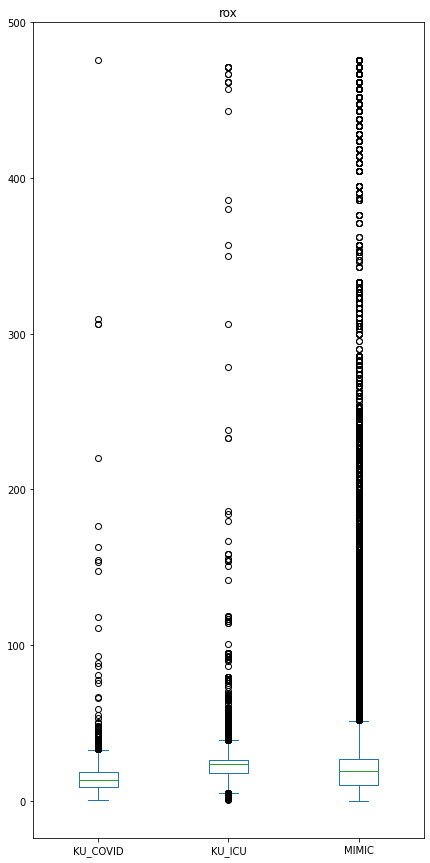

In [60]:
D_name = ['MIMIC', 'KU_ICU', 'KU_COVID', 'KU_TEST']
viz = []
for idx in range(3):
    viz.append(D[idx]['X'].reset_index().assign(dataset=D_name[idx]).drop(columns=['subject_id','hours_in']))
viz_all = pd.concat(viz)
viz_all.pivot(columns='dataset', values='rox').plot.box(figsize=(7,15),title='rox')
viz_all.describe()

In [61]:
#show distribution

#_ = ax.set_xticklabels(X_test[CBC].keys(), rotation=90)
#ax = sns.violinplot(data=df[CBC],split=True)
#ax = sns.catplot(data=df[COLS])
if PLOT_DIST:
    plt.figure(figsize=(30, 10))
    ax = sns.boxplot(data=D[0]['X'][COLS], palette="Set2")
    plt.show()

In [62]:
patient_mean = []
for i in range(len(files)):
    patient_mean.append(D[i]['X'].groupby('subject_id').mean().reset_index().set_index(ID_COLS))
patient_mean[2]

,,,,absolute_time,rr,hr,spo2,sbp,dbp,temp,hct,hb,platelets,...,fio2,pfratio,age,gender_F,gender_M,rox,mews,news,sofa,qsofa
subject_id,hadm_id,icustay_id,hours_in,,,,,,,,,,,,,,,,,,,,,
300003674.000,0.000,0.000,78.000,11.535,22.548,80.459,95.439,130.331,69.968,36.808,42.973,14.734,242.669,...,0.784,104.759,73.000,0.000,1.000,5.847,1.815,2.866,3.573,1.611
300243763.000,0.000,0.000,75.000,11.517,18.379,73.959,97.055,130.117,87.917,36.360,39.823,13.772,378.345,...,0.350,273.195,55.000,0.000,1.000,16.473,1.345,1.048,1.972,1.000
300334815.000,0.000,0.000,111.000,11.715,18.733,71.027,96.290,122.860,65.986,36.731,40.020,13.493,221.421,...,0.277,281.824,47.000,0.000,1.000,19.234,1.416,1.516,2.005,1.000
300401259.000,0.000,0.000,113.500,11.816,22.518,60.346,93.605,134.864,78.886,36.692,29.814,9.704,129.469,...,0.408,227.346,71.000,0.000,1.000,11.312,1.829,3.039,3.425,1.000
300419445.000,0.000,0.000,65.500,10.962,17.269,98.077,97.246,140.762,91.969,36.636,31.931,10.915,81.092,...,0.434,209.052,75.000,0.000,1.000,14.186,1.831,1.754,4.446,1.008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302063282.000,0.000,0.000,54.424,11.207,19.033,70.554,94.587,131.130,63.000,36.475,26.910,9.408,132.478,...,0.547,119.495,72.000,0.000,1.000,9.618,1.370,1.750,4.402,1.511
302063527.000,0.000,0.000,114.000,11.815,19.476,96.097,99.070,116.291,70.581,36.992,24.584,8.485,76.828,...,0.243,309.239,60.000,0.000,1.000,22.153,2.207,2.661,3.639,1.000
302064074.000,0.000,0.000,134.857,11.246,18.514,66.543,96.137,106.263,66.006,36.786,33.287,11.109,352.537,...,0.439,246.793,67.000,1.000,0.000,13.841,1.691,2.269,2.154,1.011


In [63]:
print(patient_mean[0].corr()[patient_mean[2].corr().abs().apply(lambda row: row.nlargest(2).values[-1],axis=1) > 0.5].index)
print(patient_mean[1].corr()[patient_mean[2].corr().abs().apply(lambda row: row.nlargest(2).values[-1],axis=1) > 0.5].index)
print(patient_mean[2].corr()[patient_mean[2].corr().abs().apply(lambda row: row.nlargest(2).values[-1],axis=1) > 0.5].index)
print(patient_mean[3].corr()[patient_mean[3].corr().abs().apply(lambda row: row.nlargest(2).values[-1],axis=1) > 0.5].index)

Index(['rr', 'hr', 'spo2', 'sbp', 'dbp', 'hct', 'hb', 'rbc', 'mch', 'mcv',
       'hco3', 'po2', 'pco2', 'sao2', 'fio2', 'pfratio', 'gender_F',
       'gender_M', 'rox', 'mews', 'news', 'sofa', 'qsofa'],
      dtype='object')
Index(['rr', 'hr', 'spo2', 'sbp', 'dbp', 'hct', 'hb', 'rbc', 'mch', 'mcv',
       'hco3', 'po2', 'pco2', 'sao2', 'fio2', 'pfratio', 'gender_F',
       'gender_M', 'rox', 'mews', 'news', 'sofa', 'qsofa'],
      dtype='object')
Index(['rr', 'hr', 'spo2', 'sbp', 'dbp', 'hct', 'hb', 'rbc', 'mch', 'mcv',
       'hco3', 'po2', 'pco2', 'sao2', 'fio2', 'pfratio', 'gender_F',
       'gender_M', 'rox', 'mews', 'news', 'sofa', 'qsofa'],
      dtype='object')
Index(['rr', 'hr', 'sbp', 'dbp', 'hct', 'hb', 'platelets', 'rbc', 'mch',
       'mchc', 'mcv', 'ph', 'hco3', 'pco2', 'sao2', 'fio2', 'pfratio',
       'gender_F', 'gender_M', 'rox', 'mews', 'news', 'sofa', 'qsofa'],
      dtype='object')


In [64]:
if PLOT_DIST:
    plt.figure(figsize=(10,10))
    plt.title('Correlation: CBC', y=1.05, size=15)
    ax = sns.heatmap(patient_mean[0][CBC].corr(),linewidths=0.1,vmax=1.0,square=True, cmap="YlGnBu", linecolor='white', annot=True)
    plt.show()

In [65]:
if PLOT_DIST:
    plt.figure(figsize=(10,10))
    plt.title('Correlation: ABGA', y=1.05, size=15)
    ax = sns.heatmap(patient_mean[0][ABGA].corr(),linewidths=0.1,vmax=1.0,square=True, cmap="YlGnBu", linecolor='white', annot=True)
    plt.show()

In [66]:
if PLOT_DIST:
    plt.figure(figsize=(20,20))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    ax = sns.heatmap(patient_mean[0].corr(),linewidths=0.1,vmax=1.0,square=True, cmap="YlGnBu", linecolor='white', annot=True)
    plt.show()

In [67]:
if PLOT_DIST:
    high_corr_col = ['sbp', 'dbp',  'hct', 'hb', 'rbc', 'mch', 'mcv', 'hco3','pco2']

    hicc = []
    for idx in range(3):
        temp = patient_mean[idx].reset_index(drop=True)[ABGA]
        hicc.append(temp.assign(dataset=D_name[idx]))

    hicc_df = pd.concat(hicc).reset_index(drop=True)

    pair_grid = sns.pairplot(hicc_df, height = 2.5, palette="YlGnBu", hue='dataset', plot_kws={'alpha':0.8})
    pair_grid = pair_grid.map_diag(sns.distplot, rug=True)
    plt.show()

In [68]:
if PLOT_DIST:
    high_corr_col = ['sbp', 'dbp',  'hct', 'hb', 'rbc', 'mch', 'mcv', 'hco3','pco2']

    hicc = []
    for idx in range(3):
        temp = patient_mean[idx].reset_index(drop=True)[CBC]
        hicc.append(temp.assign(dataset=D_name[idx]))

    hicc_df = pd.concat(hicc).reset_index(drop=True)

    pair_grid = sns.pairplot(hicc_df, height = 2.5, palette="YlGnBu", hue='dataset', plot_kws={'alpha':0.8})
    pair_grid = pair_grid.map_diag(sns.distplot, rug=True)
    plt.show()

In [69]:
if PLOT_DIST:
    high_corr_col = ['sbp', 'dbp',  'hct', 'hb', 'rbc', 'mch', 'mcv', 'hco3','pco2']

    hicc = []
    for idx in range(3):
        temp = patient_mean[idx].reset_index(drop=True)[vital]
        hicc.append(temp.assign(dataset=D_name[idx]))

    hicc_df = pd.concat(hicc).reset_index(drop=True)

    pair_grid = sns.pairplot(hicc_df, height = 2.5, palette="YlGnBu", hue='dataset', plot_kws={'alpha':0.8})
    pair_grid = pair_grid.map_diag(sns.distplot, rug=True)
    plt.show()

In [70]:
#extract index
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(D[0]['info'].reset_index(drop=True), test_size=0.2, 
    random_state=RANDOM, stratify=D[0]['info']['MV_ICU'])

#normalization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

#extract train patient data
X_ = D[0]['X'].reset_index()
train_data = X_[X_['subject_id'].isin(train_ids['subject_id'])]
train_data = train_data.set_index(ID_COLS)

vital = ['rr','hr','spo2','sbp','dbp','temp']
CBC = ['hct','hb','platelets','wbc','rbc','mch','mchc','mcv']
ABGA = ['ph','hco3', 'po2','pco2','sao2','fio2','pfratio']
COLS = vital+CBC+ABGA
ID_COLS= ['subject_id', 'hadm_id', 'icustay_id', 'hours_in']

#fit standard scaler with train data, and transform all data
fitted = std_scaler.fit(train_data[COLS+['age']])

for i in range(len(files)):
    D[i]['X'][COLS+['age']] = std_scaler.transform(D[i]['X'][COLS+['age']])

if PLOT_DIST:
    for i in range(len(files)):
        plt.figure(figsize=(30, 15))
        ax = sns.boxplot(data=D[i]['X'][COLS+['age']], palette="Set2")
        plt.show()

In [71]:
D[0]['X'].columns
['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'absolute_time',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M', 'rox', 'mews']

['subject_id',
 'hadm_id',
 'icustay_id',
 'hours_in',
 'absolute_time',
 'rr',
 'hr',
 'spo2',
 'sbp',
 'dbp',
 'temp',
 'ph',
 'hco3',
 'po2',
 'pco2',
 'sao2',
 'fio2',
 'pfratio',
 'age',
 'gender_F',
 'gender_M',
 'rox',
 'mews']

In [72]:
# remove index, transform to 240h frame with zeros

def create_x_matrix(x):
    zeros = np.zeros((MAX_LEN, x.shape[1]-4))
    x = x.values
    x = x[:(MAX_LEN), 4:]
    zeros[0:x.shape[0], :] = x
    return zeros

def create_y_matrix(y):
    zeros = np.zeros((MAX_LEN+PREDICTION_WINDOW+GRAY_AREA, y.shape[1]-4))
    y = y.values
    y = y[:,4:]
    y = y[:MAX_LEN+PREDICTION_WINDOW+GRAY_AREA, :]
    zeros[:y.shape[0], :] = y
    return zeros

cols_without_CBC = ['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'absolute_time',
       'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M', 'rox', 'mews']

T = [] # tensorized data
for i in range(len(files)):
    temp = {}
    if NO_CBC:
        COLS = cols_without_CBC
        temp['X'] = np.array(list(D[i]['X'][cols_without_CBC].groupby('subject_id').apply(create_x_matrix)))
    else:
        temp['X'] = np.array(list(D[i]['X'].groupby('subject_id').apply(create_x_matrix)))
    temp['Y'] = np.array(list(D[i]['Y'].groupby('subject_id').apply(create_y_matrix)))[:,:,0]
    temp['lengths'] = np.array(list(D[i]['X'].groupby('subject_id').apply(lambda x: x.shape[0])))
    T.append(temp)

key = pd.Series(D[0]['X'].reset_index()['subject_id'].unique())
#train/valid indices for mimic
train_indices = np.where(key.isin(train_ids['subject_id']))[0]
valid_indices = np.where(key.isin(valid_ids['subject_id']))[0]
train = {'X' : T[0]['X'][train_indices],  'Y' : T[0]['Y'][train_indices], 'lengths' : T[0]['lengths'][train_indices]}
valid = {'X' : T[0]['X'][valid_indices],  'Y' : T[0]['Y'][valid_indices], 'lengths' : T[0]['lengths'][valid_indices]}
T.pop(0) # remove MIMIC-all
T.insert(0,train)
T.insert(1,valid)

# T = [train,valid,kuicu,kucovid]

for i in range(len(files)+1):
    print(f"index {i}: X tensor shape: {T[i]['X'].shape}")
    print(f"index {i}: Y tensor shape: {T[i]['Y'].shape}")
    print(f"index {i}: lengths tensor shape: {T[i]['lengths'].shape}")

index 0: X tensor shape: (20612, 240, 30)
index 0: Y tensor shape: (20612, 255)
index 0: lengths tensor shape: (20612,)
index 1: X tensor shape: (5153, 240, 30)
index 1: Y tensor shape: (5153, 255)
index 1: lengths tensor shape: (5153,)
index 2: X tensor shape: (1683, 240, 30)
index 2: Y tensor shape: (1683, 255)
index 2: lengths tensor shape: (1683,)
index 3: X tensor shape: (107, 240, 30)
index 3: Y tensor shape: (107, 255)
index 3: lengths tensor shape: (107,)
index 4: X tensor shape: (294, 240, 30)
index 4: Y tensor shape: (294, 255)
index 4: lengths tensor shape: (294,)


In [73]:
print(T[3]['X'][:,:,-2][0][:5])
D[2]['X']['rox'].head()

[0. 0. 4. 4. 4.]


0   25.926
1   18.667
2    4.311
3    4.646
4    6.667
Name: rox, dtype: float64

In [74]:
print(T[3]['X'][:,:,-1][0][:5])
D[2]['X']['mews'].head()

[1. 1. 2. 2. 2.]


0    1
1    2
2    2
3    2
4    1
Name: mews, dtype: int64

In [75]:
T[0]['lengths']

array([41, 89, 39, ..., 76, 48, 27])

In [76]:
T[2]['Y'].sum()

1339.0

## Stratified Sampling

In [77]:
def tensorize(X_tensor, Y_tensor, lengths, gray=False, limit=False):
    num_patients = X_tensor.shape[0]
    timesteps = X_tensor.shape[1]
    num_features = X_tensor.shape[2]
    
    X_tensor_new = np.zeros((lengths.sum(), SLICE_SIZE, num_features))
    Y_tensor_new = np.zeros((lengths.sum()))
    
    MAX_ROWS_PER_PATIENTS = 72
    
    gray_cnt = 0
    limit_cnt = 0
    current_row = 0
    for patient_index in range(num_patients):
        x_patient = X_tensor[patient_index]
        y_patient = Y_tensor[patient_index]
        length = lengths[patient_index]

        if((limit==True) & (length - SLICE_SIZE > MAX_ROWS_PER_PATIENTS)):
            timesteps = sorted(random.sample(range(length - SLICE_SIZE),MAX_ROWS_PER_PATIENTS))
            limit_cnt += (length - SLICE_SIZE) - MAX_ROWS_PER_PATIENTS
        else:
            timesteps = range(length - SLICE_SIZE)

        for timestep in timesteps:
            result = None
            x_window = x_patient[timestep:timestep+SLICE_SIZE]
            # if num_patients < 300 and num_patients > 250:

            if x_window.shape[0] != 6:
                break

            y_window = y_patient[timestep:timestep+SLICE_SIZE]
            result_window = y_patient[timestep+SLICE_SIZE:timestep+SLICE_SIZE+PREDICTION_WINDOW]
            gray_window = y_patient[timestep+SLICE_SIZE+PREDICTION_WINDOW:timestep+SLICE_SIZE+PREDICTION_WINDOW+GRAY_AREA]
            
            if (max(result_window, default=0)==1):
                result = 1
            elif (max(result_window, default=0)==0):
                result = 0
                if(gray==True):
                    gray_window = y_patient[timestep+SLICE_SIZE+PREDICTION_WINDOW:timestep+SLICE_SIZE+PREDICTION_WINDOW+GRAY_AREA]
                    if max(gray_window, default=0) == 1:
                        gray_cnt += 1
                        result = None

            if result != None:
                X_tensor_new[current_row] = x_window
                Y_tensor_new[current_row] = result
                current_row += 1

    X_tensor_new = X_tensor_new[:current_row,:,:]
    Y_tensor_new = Y_tensor_new[:current_row]

    print("Gray-dropped: ", gray_cnt)
    print("limit-dropped: ", limit_cnt)
    return X_tensor_new, Y_tensor_new

In [78]:
print(T[0]['X'].shape)
print(T[0]['Y'].shape)
print(T[0]['lengths'].shape)

(20612, 240, 30)
(20612, 255)
(20612,)


In [79]:
X = []
Y = []
for i in range(len(files)+1):
    print(f"index {i}")
    if i < 1: 
        x, y = tensorize(T[i]['X'],T[i]['Y'],T[i]['lengths'], gray=GRAY, limit=LIMIT_TIMESTEP)
    else:
        x, y = tensorize(T[i]['X'],T[i]['Y'],T[i]['lengths'], gray=False, limit=False)
    print(f"X tensor shape: {x.shape}")
    print(f"Y tensor shape: {y.shape}")
    print(f"Y positive: {y.sum()}")
    print(f"class ratio: {y.sum()/len(y)}")
    X.append(x)
    Y.append(y)

index 0


Gray-dropped:  0
limit-dropped:  0
X tensor shape: (1035751, 6, 30)
Y tensor shape: (1035751,)
Y positive: 44704.0
class ratio: 0.04316095277726017
index 1
Gray-dropped:  0
limit-dropped:  0
X tensor shape: (257314, 6, 30)
Y tensor shape: (257314,)
Y positive: 9803.0
class ratio: 0.03809742182702846
index 2
Gray-dropped:  0
limit-dropped:  0
X tensor shape: (114869, 6, 30)
Y tensor shape: (114869,)
Y positive: 1260.0
class ratio: 0.010969016880098199
index 3
Gray-dropped:  0
limit-dropped:  0
X tensor shape: (13710, 6, 30)
Y tensor shape: (13710,)
Y positive: 564.0
class ratio: 0.04113785557986871
index 4
Gray-dropped:  0
limit-dropped:  0
X tensor shape: (21805, 6, 30)
Y tensor shape: (21805,)
Y positive: 941.0
class ratio: 0.04315523962393946


In [80]:
#Extract MEWS
Rox = []
Mews = []
News = []
SOFA = []
qSOFA = []

for i in range(len(files)):
    Rox.append(X[i][:,-1,-5])
    Mews.append(X[i][:,-1,-4])
    News.append(X[i][:,-1,-3])
    SOFA.append(X[i][:,-1,-2])
    qSOFA.append(X[i][:,-1,-1])

def extract_max(ls):
    max_val = max(max(ls[1]), max(ls[2]), max(ls[0]))
    #print(max_val)
    return max_val

max_ROX = extract_max(Rox)
max_MEWS = extract_max(Mews)
max_NEWS = extract_max(News)
max_SOFA = extract_max(SOFA)
max_qSOFA = extract_max(qSOFA)

rox_prob = []
mews_prob = []
news_prob = []
sofa_prob = []
qsofa_prob = []

for i in range(len(files)):
    rox_prob.append(1 - Rox[i]/max_ROX)
    mews_prob.append(Mews[i]/max_MEWS)
    news_prob.append(News[i]/max_NEWS)
    sofa_prob.append(SOFA[i]/max_SOFA)
    qsofa_prob.append(qSOFA[i]/max_qSOFA)

for i in range(len(files)):
    print(i)
    print(roc_auc_score(Y[i], rox_prob[i], average=None))
    print(roc_auc_score(Y[i], mews_prob[i], average=None))
    print(roc_auc_score(Y[i], news_prob[i], average=None))
    print(roc_auc_score(Y[i], sofa_prob[i], average=None))
    print(roc_auc_score(Y[i], qsofa_prob[i], average=None))

0
0.7146258674429345
0.573545893729979
0.5867427364890239
0.6921176819982149
0.5470844076311928
1
0.7456583115361685
0.6032209745615493
0.607013449570145
0.7150975299822873
0.5512838172244272
2
0.7412231236710372
0.6803374061997938
0.7115571200973765
0.6912876655619309
0.5248834208166215
3
0.8126020319531977
0.5694351381592222
0.5749874837207446
0.8098223524562659
0.6639026999556534


In [81]:
rox_prob.pop(0)
mews_prob.pop(0)
news_prob.pop(0)
sofa_prob.pop(0)
qsofa_prob.pop(0)

array([1. , 1. , 0.5, ..., 0.5, 0.5, 0.5])

In [82]:
# #X_imbalance, y_imbalance = imbalance_sampling(x_train, y_train)
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# from imblearn.under_sampling import RandomUnderSampler, NearMiss
# from collections import Counter

# def shape3dto2d(arr):
#     orig_shape = arr.shape
#     arr = arr.reshape(-1, arr.shape[1]*arr.shape[2])
#     return arr, orig_shape

# def shape2dto3d(arr, orig_shape):
#     arr = np.reshape(arr, (arr.shape[0],orig_shape[1],orig_shape[2]))
#     return arr

# def imbalance_sampling(x_train, y_train, imbtype):
#     x_train_2d, x_shape = shape3dto2d(x_train)

#     if imbtype == "ros":
#         # 1. Random Oversampling
#         ros = RandomOverSampler(random_state=42)
#         x, y= ros.fit_resample(x_train_2d, y_train)
#         x = shape2dto3d(x,x_shape)
#         #y = y[:, np.newaxis]
#     if imbtype == "smote":
#         # 2. SMOTE Oversampling for Imbalanced Dataset
#         smote = SMOTE(random_state=42)
#         x, y= smote.fit_resample(x_train_2d, y_train)
#         x = shape2dto3d(x,x_shape)
#         #y = y[:, np.newaxis]

#     if imbtype == "rus":
#         # 3. Random Under-Sampling for Imbalanced Dataset
#         rus = RandomUnderSampler(random_state=42)
#         x, y= rus.fit_resample(x_train_2d, y_train)
#         x = shape2dto3d(x,x_shape)
#         #y = y[:, np.newaxis]

#     if imbtype == "nearmiss":
#         # 4. Under-Sampling Using NearMiss for Imbalanced Dataset
#         nearmiss = NearMiss(version=3)
#         x, y= nearmiss.fit_resample(x_train_2d, y_train)
#         x = shape2dto3d(x,x_shape)
#         #y = y[:, np.newaxis]

#     return x, y

# X_imb, Y_imb = imbalance_sampling(X[0],Y[0],"ros")

In [83]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GroupKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

template=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=700))
colors=px.colors.qualitative.Vivid
def plot_roc(y_val, y_prob):
    fig=make_subplots(rows=1, cols=3)
    for i in range(len(y_val)):
        y=y_val[i]
        prob=y_prob[i]
        fpr, tpr, thresh = roc_curve(y, prob)
        roc_auc = auc(fpr,tpr)
        fig.append_trace(go.Scatter(x=fpr, y=tpr, line=dict(color=colors[i+1], width=3), 
                                    hovertemplate = 'True positive rate = %{y:.3f}, False positive rate = %{x:.3f}',
                                    name='AUC = {:.3f}  '.format(roc_auc)), 
                         row=1,col=i+1)
        fig.add_shape(type="line", xref="x", yref="y", x0=0, y0=0, x1=1, y1=1, 
                      line=dict(color="Black", width=1, dash="dot"), row=1, col=i+1)
        fig.update_xaxes(title='False Positive Rate')
    fig.update_layout(template=template, title="ROC Curves", 
                      hovermode="x unified", height=400,
                      yaxis_title='True Positive Rate (Sensitivity)', 
                      legend=dict(orientation='h',y=1.175, x=.5, xanchor="center",
                                  bordercolor="black", borderwidth=.5, font=dict(size=12)))
    fig.show()



In [84]:

template=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=700))
colors=px.colors.qualitative.Vivid

def plot_roc(y_val, y_prob):
    fpr_list = []
    tpr_list = []
    auc_list = []
    precision_list = []
    recall_list = []
    auprc_list = []
    all_pred = []
    
    all_pred = y_prob + rox_prob + mews_prob + news_prob + sofa_prob + qsofa_prob
    
    for i in range(18):
        fpr, tpr, _ = roc_curve(y_val[i%3], all_pred[i])
        pr, rec, _ = precision_recall_curve(y_val[i%3], all_pred[i])
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision_list.append(pr)
        recall_list.append(rec)
        auc_list.append(auc(fpr,tpr))
        auprc_list.append(auc(rec,pr))

    label = ['MIMIC-iii ICU Valid','KU ICU cohort','KU COVID-19 cohort']
    label2 = ['BiLSTM','ROX','MEWS', 'NEWS', 'SOFA', 'qSOFA']

    #fpr[] 0~2 = bilstm, 3~5 = rox
    fig=make_subplots(rows=1, cols=3, subplot_titles = (label))
    for i in range(3):
        for j in range(6):
            idx = j*3
            fig.append_trace(go.Scatter(x=fpr_list[i+idx], y=tpr_list[i+idx], line=dict(color=colors[j+1], width=3), 
                hovertemplate = 'True positive rate = %{tpr_list[i+idx]:.3f}, False positive rate = %{fpr_list[i+idx]:.3f}',
                name=f'{label2[j]} AUC {auc_list[i+idx]:.3f}', legendgroup=i,  legendgrouptitle_text=label[i]), 
                row=1,col=i+1)    
        fig.add_shape(type="line", xref="x", yref="y", x0=0, y0=0, x1=1, y1=1, 
            line=dict(color="Black", width=1, dash="dot"), row=1, col=i+1)  
        fig.update_xaxes(title='False Positive Rate\n')
    fig.update_layout(template=template, 
        hovermode="x", 
        height=600,
        yaxis_title='True Positive Rate (Sensitivity)')
    fig.show()   



In [85]:
# stop here
#save data
np.savez('X.npz', **{'X_{}'.format(i): X[i] for i in range(len(X))})
np.savez('Y.npz', **{'Y_{}'.format(i): Y[i] for i in range(len(Y))})
np.savez('X_sample.npz', **{'X_{}'.format(i): X[i][:1024] for i in range(len(X))})
np.savez('Y_sample.npz', **{'Y_{}'.format(i): Y[i][:1024] for i in range(len(Y))})

In [86]:
asdf

NameError: name 'asdf' is not defined

## Model Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Concatenate, GRU
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import metrics, regularizers
from sklearn.utils import class_weight
from tqdm import tqdm
class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes=np.unique(Y[0]), y =Y[0])
print(class_weights)

if USE_SCORES == False:
    for i in range(4):
        X[i] = X[i][:,:,:-5]

if USE_SCORES:
    COLS = ['absolute_time', 'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M', 'rox', 'mews']
else:
    COLS = ['absolute_time', 'rr', 'hr', 'spo2', 'sbp', 'dbp', 'temp', 'hct', 'hb', 'platelets',
       'wbc', 'rbc', 'mch', 'mchc', 'mcv', 'ph', 'hco3', 'po2', 'pco2', 'sao2',
       'fio2', 'pfratio', 'age', 'gender_F', 'gender_M']


y_valid=[]
y_prob=[]


#training param
dp = 0.4
nunit = 16
lr=1e-3
ls=0.2
epoch=10
if mode == "train":
    with tf.device("/device:GPU:0"):
        x_input = Input(shape=(X[0].shape[-2:])) # (6, 25)
        d0 = Dropout(dp)(x_input)
        x1 = Bidirectional(LSTM(units=nunit, return_sequences=True))(d0)
        d1 = Dropout(dp)(x1)
        l1 = Bidirectional(LSTM(units=nunit, return_sequences=True))(d1)
        d2 = Dropout(dp)(l1)
        l2 = Bidirectional(LSTM(units=nunit, return_sequences=False))(d2)
        d3 = Dropout(dp)(l2)
        d4 = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(d3)
        model = Model(inputs=x_input, outputs=d4, name='Bidirectional_LSTM')
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
            loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=ls), 
            metrics=[metrics.AUC(name = 'auc')])
        model.summary() 

        checkpoint_filepath = f"./result/run_{dp}_{nunit}_{lr}.hdf5"
        lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.3, min_lr=1e-6, patience=5, verbose=True)
        #es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=True)
        sv = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, monitor='val_auc', verbose=1, save_best_only=True,
            save_weights_only=False, mode='max', save_freq='epoch', options=None
        )
        print("Train shape: {}, {}, Valid shape: {}, {}".format(X[0].shape, Y[0].shape, X[1].shape, Y[1].shape))
        
        hist=model.fit(X[0], Y[0], validation_data=(X[1], Y[1]), class_weight=dict(enumerate(class_weights)), 
                epochs=epoch, batch_size=128, callbacks=[lr,sv], verbose=True)

        for i in range(1,4):
            y_prob.append(model.predict(X[i]).squeeze())  
            y_valid.append(Y[i])
        plot_roc(y_val=y_valid, y_prob=y_prob) 

        if COMPUTE_LSTM_IMPORTANCE:
            for i in range(3):
                dataset_name = ['valid','ku-icu','ku-micu']
                idx = i + 1
                results = []
                print(' Computing LSTM feature importance...')
                
                # COMPUTE BASELINE (NO SHUFFLE)
                oof_preds = model.predict(X[idx], verbose=0).squeeze() 
                baseline_mae = np.mean(np.abs( oof_preds-Y[idx] ))
                results.append({'feature':'BASELINE','mae':baseline_mae})           
                
                for k in tqdm(range(len(COLS))):
                    # SHUFFLE FEATURE K
                    save_col = X[idx][:,:,k].copy()
                    np.random.shuffle(X[idx][:,:,k])
                            
                    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                    oof_preds = model.predict(X[idx], verbose=0).squeeze() 
                    mae = np.mean(np.abs( oof_preds-Y[idx] ))
                    results.append({'feature':COLS[k],'mae':mae})
                    X[idx][:,:,k] = save_col
                

                # DISPLAY LSTM FEATURE IMPORTANCE
                print()
                df = pd.DataFrame(results)
                df = df.sort_values('mae')
                plt.figure(figsize=(10,20))
                plt.barh(np.arange(len(COLS)+1),df.mae)
                plt.yticks(np.arange(len(COLS)+1),df.feature.values)
                plt.title('LSTM Feature Importance',size=16)
                plt.ylim((-1,len(COLS)+1))
                plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
                            label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
                plt.xlabel(f'{dataset_name[i]} OOF MAE with feature permuted',size=14)
                plt.ylabel('Feature',size=14)
                plt.legend()
                plt.show()
                                    
                # SAVE LSTM FEATURE IMPORTANCE
                df = df.sort_values('mae',ascending=False)
                df.to_csv(f'lstm_feature_importance_fold_{dataset_name[i]}.csv',index=False)



In [ ]:
X[0].shape

In [ ]:
from tensorflow.keras.models import load_model
if mode == "test":
    best_model = load_model('../logs/best_model/lstm_dp04.h5')
    # best_model = load_model('./result/run_0.4_16_0.001_811.hdf5')
    
    best_model.summary()
    print("Predict severity of patients using BiLSTM Model...")

    y_valid=[]
    y_prob=[] # model prediction probability
    for i in range(1,4):
        y_prob.append(best_model.predict(X[i]).squeeze())
        y_valid.append(Y[i])    
        print(best_model.evaluate(X[i], Y[i], batch_size=128))
    acc_bilstm = accuracy_score(y_valid[1],np.where(y_prob[1]>0.5,1,0))
    print("\nBiLSTM 모델 정확도 (KU-ICU): ", acc_bilstm)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class

fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

all_test = y_valid
all_pred = y_prob + rox_prob + mews_prob +news_prob + sofa_prob + qsofa_prob

n_score=5
for i in range(3*n_score):
    fpr, tpr, _ = roc_curve(all_test[i%3], all_pred[i])
    pr, rec, _ = precision_recall_curve(all_test[i%3], all_pred[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))

lw = 2
label = ['MIMIC-iii validation dataset','KU Hospital ICU cohort','KU Hospital COVID-19 cohort']
label2 = ['MV-EWS','Rox', 'MEWS','NEWS','SOFA','qSOFA']

for j in range(3):
    plt.figure()
    for idx in range(n_score):
        i = idx*3+j
        plt.plot(
            fpr_list[i],
            tpr_list[i],
            label=label2[i//3] + ": %0.3f" % auc_list[i]
        )
    plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(label[j])
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
n_score=5
print(PREDICTION_WINDOW)
print('average_precision_score')
for i in range(n_score):
    print(label2[i])
    for j in range(3):
        idx = 3*i+ j
        print(round(average_precision_score(all_test[idx%3],all_pred[idx]),3))

In [ ]:
n_score=5
print(PREDICTION_WINDOW)
print('auprc-value')
for i in range(n_score):
    print(label2[i])
    for j in range(3):
        idx = 3*i+ j
        print(round(auprc_list[idx],3))

print()
print('auroc-value')
for i in range(n_score):
    print(label2[i])
    for j in range(3):
        idx = 3*i+ j
        print(round(auc_list[idx],3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class

fpr_list = []
tpr_list = []
auc_list = []
precision_list = []
recall_list = []
auprc_list = []

all_test = y_valid
all_pred = y_prob + rox_prob + mews_prob +news_prob + sofa_prob + qsofa_prob

n_score=5
for i in range(3*n_score):
    fpr, tpr, _ = roc_curve(all_test[i%3], all_pred[i])
    pr, rec, _ = precision_recall_curve(all_test[i%3], all_pred[i])
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc(fpr,tpr))
    precision_list.append(pr)
    recall_list.append(rec)
    auprc_list.append(auc(rec,pr))

lw = 2
label = ['MIMIC-iii validation dataset','KU Hospital ICU cohort','KU Hospital COVID-19 cohort']
label2 = ['MV-EWS','Rox', 'MEWS','NEWS','SOFA','qSOFA']

for j in range(3):
    plt.figure()
    for idx in range(n_score):
        i = idx*3+j
        plt.plot(
            recall_list[i],
            precision_list[i],
            label=label2[i//3] + ": %0.3f" % auprc_list[i]
        )
    plt.plot([0, 1], [0, 0], color="black", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(label[j])
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
import shap

model = best_model
for i in range(3):
    label = ['MIMIC-iii validation dataset','KU Hospital ICU cohort','KU Hospital COVID-19 cohort']
    dataset_name = ['mimic','ku-icu','ku-covid']
    idx = i + 1
    results = []
            
    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X[idx], verbose=0).squeeze() 
    # baseline_mae = np.mean(np.abs( oof_preds-Y[idx] ))
    baseline_auc = roc_auc_score(Y[idx],oof_preds)
    print(baseline_auc)
    #results.append({'feature':'BASELINE','auc':baseline_auc})        
    
    for k in tqdm(range(len(COLS))):
        # SHUFFLE FEATURE K
        save_col = X[idx][:,:,k].copy()
        X[idx][:,:,k]=0
        #np.random.shuffle(X[idx][:,:,k])
                
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X[idx], verbose=0).squeeze() 
        auc_diff = abs(roc_auc_score(Y[idx],oof_preds) - baseline_auc)
        results.append({'feature':COLS[k],'auc_diff':auc_diff})
        X[idx][:,:,k] = save_col
    

    # DISPLAY LSTM FEATURE IMPORTANCE
    print()
    df = pd.DataFrame(results)
    df = df.sort_values('auc_diff')
    plt.figure(figsize=(7,12))
    plt.barh(np.arange(len(COLS)),df.auc_diff)
    plt.yticks(np.arange(len(COLS)),df.feature.values)
    plt.title('Feature Importance',size=12)
    plt.ylim((-1,len(COLS)))
    plt.plot([0,0],[-1,len(COLS)], '--', color='orange',
                label=f'Baseline OOF\nAUC={baseline_auc:.3f}')
    plt.xlabel(f'{label[i]} AUC loss',size=12)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
                        
    # SAVE LSTM FEATURE IMPORTANCE
    df = df.sort_values('auc_diff',ascending=False)
    df.to_csv(f'lstm_feature_importance_fold_{dataset_name[i]}_{PREDICTION_WINDOW}.csv',index=False)
    
    df['value'] = df['value'] / df['value'].sum()

    shap.force_plot(0,np.array(df['value']),np.array(df['feature']), out_names = str(PREDICTION_WINDOW)+"feature importance", link='identity',matplotlib=True)



In [ ]:
import shap
import pandas as pd
import numpy as np

t1 = pd.read_csv("PI_mimic-valid_12.csv")
t2 = pd.read_csv("PI_mimic-valid_24.csv")
t1['value'] = t1['value'] / t1['value'].sum()
t2['value'] = t2['value'] / t2['value'].sum()

shap.force_plot(0,np.array(t1['value']),np.array(t1['feature']), out_names = "12-hour feature importance", link='identity',matplotlib=True)
shap.force_plot(0,np.array(t2['value']),np.array(t2['feature']), out_names = "24-hour feature importance", link='identity',matplotlib=True)
